In [171]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from my_helpers import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode

In [365]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [270]:
df.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [272]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5, 0, 'Age')

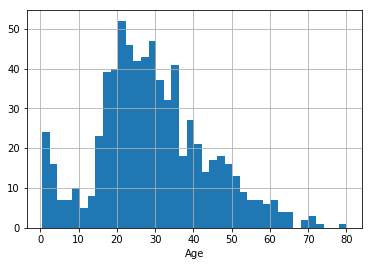

In [273]:
df['Age'].hist(bins=40)
plt.xlabel('Age')

Helper functions to create new features and cleanup existing data

In [274]:
def substrings_in_string(string, substrings):
    for substring in substrings:
        if substring in string:
            return substring
    return np.nan

def replace_titles(x):
        title = x['Title']
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Countess', 'Mme']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title == 'Dr':
            if x['Sex'] == 'Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return title

In [458]:
def clean_and_add_features(df):
    df = df.drop(['Ticket'], axis=1)
    df['Fare'] = df['Fare'].map(lambda x: np.nan if x == 0 else x)
    df['Cabin'] = df['Cabin'].fillna('Unknown')

    title_list = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr',
                  'Ms', 'Mlle', 'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']

    df['Title'] = df['Name'].map(lambda x: substrings_in_string(x, title_list))
    df['Title'] = df.apply(replace_titles, axis=1)

    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
    df['Deck'] = df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
    df['Family_Size'] = df['SibSp'] + df['Parch']

    classmeans = df.pivot_table('Fare', columns='Pclass', aggfunc='mean')
    df['Fare'] = df[['Fare', 'Pclass']].apply(lambda x: classmeans[x['Pclass']] if pd.isnull(x['Fare']) else x['Fare'], axis=1)
    meanAge = np.mean(df['Age'])
    df['Age'] = df['Age'].fillna(meanAge)

    modeEmbarked = mode(df.Embarked)[0][0]
    df['Embarked'] = df['Embarked'].fillna(modeEmbarked)
    
    df['Fare'] = pd.qcut(df['Fare'], 10)

    cols = ['Sex', 'Embarked', 'Title', 'Deck', 'Fare']

    for x in cols:
        le = preprocessing.LabelEncoder()
        le.fit(df[x])
        df[x] = le.transform(df[x])

    return df

In [459]:
df_processed = clean_and_add_features(df.copy())

In [460]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null int64
Cabin          891 non-null object
Embarked       891 non-null int64
Title          891 non-null int64
Deck           891 non-null int64
Family_Size    891 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 97.5+ KB


Let's see who survived

In [461]:
df_processed[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,0,0.575000
1,1,0.703297
2,2,0.158192
3,3,0.775362


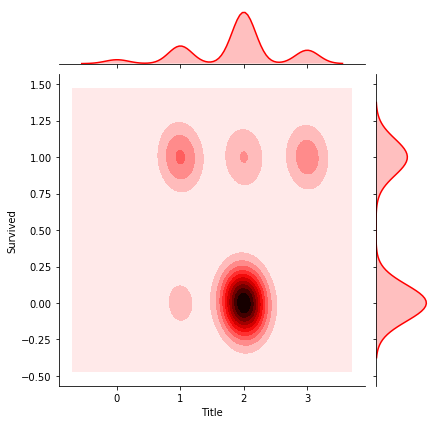

In [462]:
sns.jointplot(data=df_processed, x='Title', y='Survived', color='red', kind='kde', )

In [415]:
df[['Pclass', 'Survived']].groupby(
    ['Pclass'], as_index=False
).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


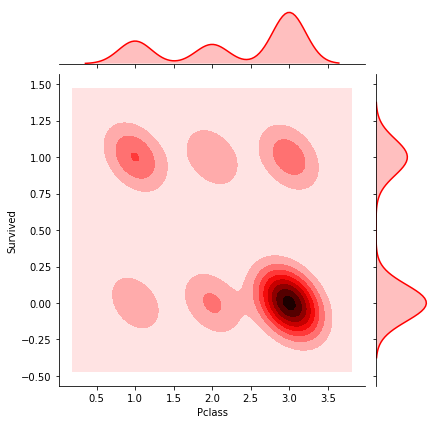

In [377]:
sns.jointplot(data=df_processed, x='Pclass', y='Survived', color='red', kind='kde')

In [416]:
df[["Sex", "Survived"]].groupby(
    ['Sex'], as_index=False
).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


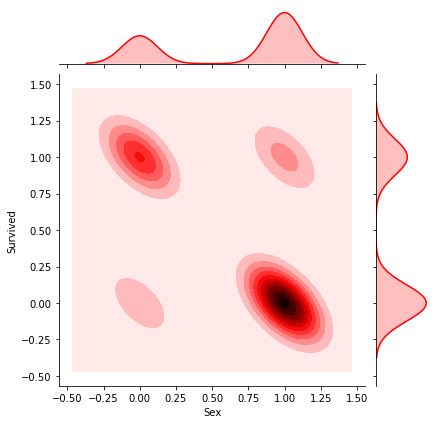

In [378]:
sns.jointplot(data=df_processed, x='Sex', y='Survived', color='red', kind='kde')

In [501]:
used_columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Title',
       'Family_Size']

df_processed = df_processed[used_columns]

In [502]:
train_data, test_data, train_labels, test_labels = train_test_split(
    df_processed.drop('Survived', axis=1), 
    df_processed['Survived'], 
    test_size=0.2, 
    random_state=42
)

train_data, validation_data, train_labels, validation_labels = train_test_split(
    train_data, 
    train_labels, 
    test_size=0.2, 
    random_state=42
)

In [503]:
print([x.shape for x in (train_data, train_labels, validation_data, validation_labels, test_data, test_labels)])

[(569, 9), (569,), (143, 9), (143,), (179, 9), (179,)]


In [504]:
train_data.head().T

,517,792,472,483,9
Pclass,3.000000,3.000000,2.0,3.0,2.0
Sex,1.000000,0.000000,0.0,0.0,0.0
Age,29.699118,29.699118,33.0,63.0,14.0
SibSp,0.000000,8.000000,1.0,0.0,1.0
Parch,0.000000,2.000000,2.0,0.0,0.0
Fare,6.000000,8.000000,7.0,3.0,7.0
Embarked,1.000000,2.000000,2.0,2.0,0.0
Title,2.000000,1.000000,3.0,3.0,3.0
Family_Size,0.000000,10.000000,3.0,0.0,1.0


In [505]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=4)

In [506]:
dtc.fit(train_data, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

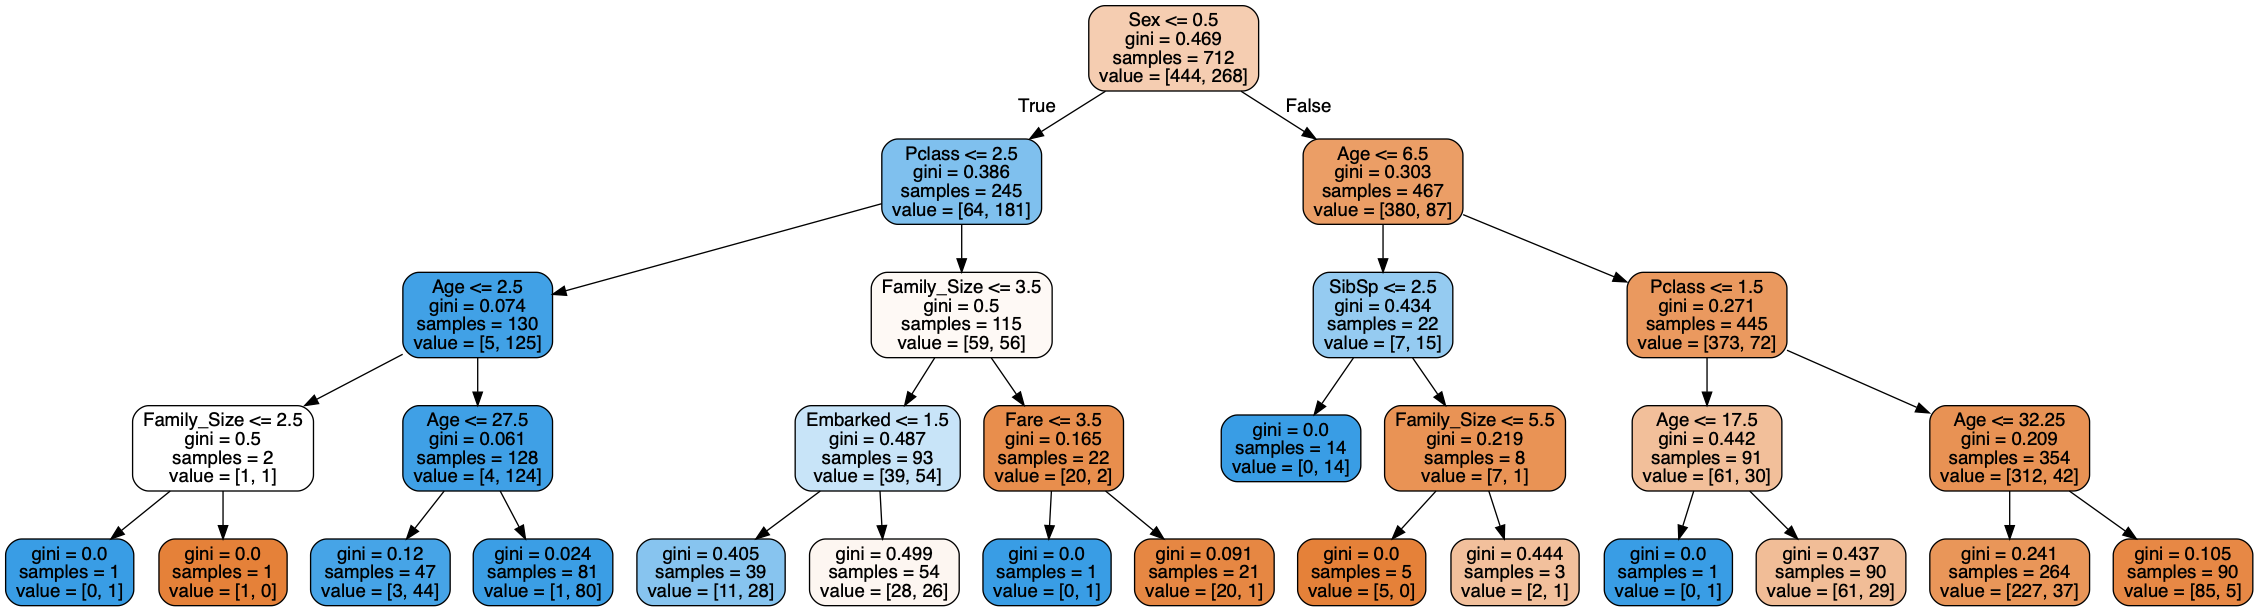

In [452]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(test_data.columns)

dot_data = StringIO()
export_graphviz(
    dtc,
    out_file=dot_data,
    feature_names=features,
    filled=True,
    rounded=True,
)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

In [507]:
predictions = dtc.predict(test_data)
score_model(dtc, train_data, train_labels, test_data, test_labels)

Accuracy on training set: 0.840
Accuracy on test set: 0.810


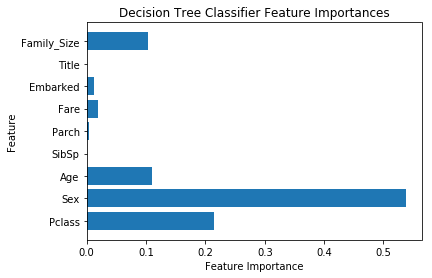

In [508]:
show_feature_importances('Decision Tree Classifier Feature Importances', train_data, dtc)

In [509]:
from sklearn.metrics import confusion_matrix, classification_report

In [510]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [512]:
from sklearn.ensemble import RandomForestClassifier

In [472]:
parameters = {
    'max_depth': [1, 5, 8, 9, 10, 11],
    'min_samples_split': np.linspace(0.1, 0.5, 12),
    'min_samples_leaf': np.linspace(0.1, 0.5, 10),
    'random_state': [0],
}

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt', n_estimators=50, oob_score = True)
clf = GridSearchCV(rfc, parameters, cv=5, n_jobs=-1, verbose=True)

clf.fit(train_data, train_labels)
print(clf.score(train_data, train_labels))
print(clf.best_params_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  1.3min finished


0.7823033707865169
{'max_depth': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'random_state': 0}


In [513]:
rfc = RandomForestClassifier(
    n_estimators=5000,
    max_depth= 5,
    min_samples_leaf = 0.1,
    min_samples_split = 0.5,
    max_features= 'sqrt',
    oob_score = True,
    n_jobs=-1
)

In [514]:
rfc.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.5,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [515]:
predictions = rfc.predict(test_data)
score_model(rfc, train_data, train_labels, test_data, test_labels)

Accuracy on training set: 0.770
Accuracy on test set: 0.810


In [394]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       105
           1       0.76      0.78      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.81      0.81      0.81       179



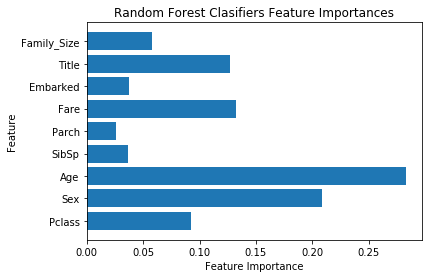

In [395]:
show_feature_importances('Random Forest Clasifiers Feature Importances', train_data, rfc)

In [396]:
from sklearn.ensemble import GradientBoostingClassifier

In [397]:
gbc = GradientBoostingClassifier(random_state=0, max_depth=4, max_features=2, learning_rate=0.04)
gbc.fit(train_data, train_labels)
score_model(gbc, train_data, train_labels, test_data, test_labels)

Accuracy on training set: 0.869
Accuracy on test set: 0.816


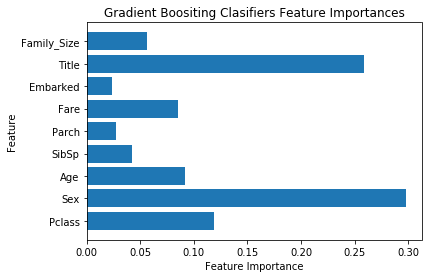

In [398]:
show_feature_importances('Gradient Boositing Clasifiers Feature Importances', train_data, gbc)

In [225]:
parameters = {
    "loss": ["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(1, 5, 10),
    "max_depth": [3, 5, 8],
    "max_features": ["log2", "sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample": [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]
}

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1, verbose=True)

clf.fit(train_data, train_labels)
print(clf.score(train_data, train_labels))
print(clf.best_params_)

Fitting 3 folds for each of 84672 candidates, totalling 254016 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 655 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2551 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 6751 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 12151 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 18751 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 26551 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 35551 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 45751 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 57151 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 69751 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 83551 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 98551 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 114751 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1321

0.8174157303370787
{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.2090909090909091, 'n_estimators': 10, 'subsample': 0.95}


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [464]:
gbc = GradientBoostingClassifier(
    criterion='friedman_mse',
    n_estimators= 1000,
    max_depth=8, 
    max_features='sqrt', 
    min_samples_leaf=0.1, 
    min_samples_split=0.21,
    learning_rate=0.2, 
    loss='deviance',
    subsample=0.95
)
gbc.fit(train_data, train_labels)
score_model(gbc, train_data, train_labels, test_data, test_labels)

Accuracy on training set: 0.916
Accuracy on test set: 0.821


In [400]:
predictions = gbc.predict(test_data)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       105
           1       0.81      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



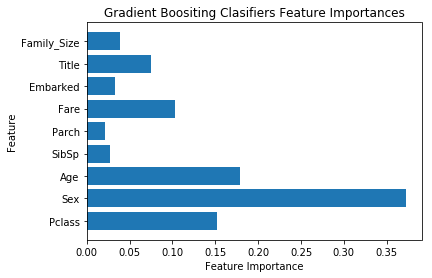

In [401]:
show_feature_importances('Gradient Boositing Clasifiers Feature Importances', train_data, gbc)

In [488]:
gbc.fit(df_processed[['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Title',
       'Family_Size']], df_processed['Survived'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=8,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=0.1, min_samples_split=0.21,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.95, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [402]:
from sklearn.externals import joblib

filename = 'finalized_model.sav'
joblib.dump(gbc, filename)

['finalized_model.sav']

In [403]:
df_tests_processed = clean_and_add_features(test_df.copy())

In [490]:
predictions_test = gbc.predict(df_tests_processed[['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Title',
       'Family_Size']])

In [483]:
rfc = RandomForestClassifier(
    n_estimators=5000,
    max_depth= 5,
    min_samples_leaf = 0.1,
    min_samples_split = 0.5,
    max_features= 'sqrt',
    oob_score = True,
    n_jobs=-1
)
rfc.fit(df_processed[['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Title',
       'Family_Size']], df_processed['Survived'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.5,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [484]:
predictions_test = rfc.predict(df_tests_processed[['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Title',
       'Family_Size']])

In [519]:
df_tests_processed['Survived'] = predictions_test

In [492]:
submission = df_tests_processed[['PassengerId', 'Survived']]

In [493]:
submission.to_csv('kaggle_submission.csv', index=False)